In [1]:
from __future__ import print_function
import time

import numpy as np
np.random.seed(1234)
from functools import reduce
import math as m

import scipy.io


from scipy.interpolate import griddata
from sklearn.preprocessing import scale



def azim_proj(pos):
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, m.pi / 2 - elev)


def gen_images(locs, features, n_gridpoints, normalize=True,
                std_mult=0.1, n_components=2):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images

    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    print(features.shape[1])
    print(nElectrodes)
    assert features.shape[1] % nElectrodes == 0
    n_colors =int(features.shape[1] / nElectrodes)
    for c in range(int(n_colors)):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])
    nSamples = features.shape[0]
    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Generate edgeless images
 
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                    method='cubic', fill_value=np.nan)
        print('Interpolating {0}/{1}\r'.format(i+1, nSamples), end='\r')
        
    # Normalizing
    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
        temp_interp[c] = np.nan_to_num(temp_interp[c])
    return np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]


def get_fft(snippet):
    Fs = 128.0;  # sampling rate
    #Ts = len(snippet)/Fs/Fs; # sampling interval
    snippet_time = len(snippet)/Fs
    Ts = 1.0/Fs; # sampling interval
    t = np.arange(0,snippet_time,Ts) # time vector

    # ff = 5;   # frequency of the signal
    # y = np.sin(2*np.pi*ff*t)
    y = snippet
#     print('Ts: ',Ts)
#     print(t)
#     print(y.shape)
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(n//2)] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(n//2)]
    #Added in: (To remove bias.)
    #Y[0] = 0
    return frq,abs(Y)

def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,12)
    beta_range = (12,40)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta

def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 128.0
    frame_length = Fs*frame_duration
    frames = []
    frames_ar_alpha= []
    frames_ar_theta= []
    frames_ar_beta= []
    steps = np.arange(0,len(df),frame_length)
    for i,_ in enumerate(steps):
        frame = []
        ar_alpha= []
        ar_theta= []
        ar_beta= []
        if i == 0:
            continue
        else:
            for channel in df.columns:
                snippet = np.array(df.ix[steps[i-1]:steps[i]-1,int(channel)])
                #print(i, channel)
                f,Y =  get_fft(snippet)
                theta, alpha, beta = theta_alpha_beta_averages(f,Y)
                #print theta, alpha, beta
                ar_alpha.append([alpha])
                ar_theta.append([theta])
                ar_beta.append([beta])
                frame.append([theta, alpha, beta])
            
        frames.append(frame)
        '''        
        print("________________Frame_no {"+str(i)+"}________________")
        plt.figure(figsize=(50, 6))
        plt.plot(ar_theta,color='green',label='theta')
        plt.plot(ar_alpha,color='blue',label='alpha')
        plt.plot(ar_beta,color='red', label='beta' )
        plt.legend()
        #plt.xlabel('sampled time',fontsize=35)
        #plt.ylabel('Hz',fontsize=35)
        #plt.title('EEG channel '+str(d[i]), fontsize=35)
        plt.xlabel('Sensors')
        plt.ylabel('AVG (freq)');
        plt.show()
        '''
    #print(len(frames))
    
    return np.array(frames)

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
import re
import matplotlib.pyplot as plt


%matplotlib inline
plt.style.use('ggplot')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (12,12)
pd.options.display.max_columns = None
pd.options.display.precision = 4
val=1


In [2]:
locs_2d = [(-2.0,4.0), #af3
                   (2.0,4.0), #af4
                   (-1.0,3.0),#f3
                   (1.0,3.0),#f4
                   (-3.0,3.0),#f7
                   (3.0,3.0),#f8
                   (-2.0,2.0),#fc5
                   (2.0,2.0),#fc6
                   (-2.0,-2.0),#p7
                   (2.0,-2.0),#p8
                   (-4.0,1.0),#t7
                   (4.0,1.0),#t8
                   (-1.0,-3.0),#o1
                   (1.0,-3.0)] #o2

In [4]:
def make_data_pipeline(file_names,labels,image_size,frame_duration,overlap):
    '''
    IN: 
    file_names - list of strings for each input file (one for each subject)
    labels - list of labels for each
    image_size - int size of output images in form (x, x)
    frame_duration - time length of each frame (seconds)
    overlap - float fraction of frame to overlap in range (0,1)
    
    OUT:
    X: np array of frames (unshuffled)
    y: np array of label for each frame (1 or 0)
    '''
    Fs = 128.0   #sampling rate
    frame_length = Fs * frame_duration
    
    print('Generating training data...')
    
    
    for i, file in enumerate(file_names):
        print ('Processing session: ',file, '. (',i+1,' of ',len(file_names),')')
        
        data=pd.read_csv(file)
        data=data.drop(['Unnamed: 0'], axis=1)
        df = pd.DataFrame(data)
        #print(df)
        
        X_0 = make_frames(df,frame_duration)
        #steps = np.arange(0,len(df),frame_length)
        X_1 = X_0.reshape(len(X_0),14*3)
        
        images = gen_images(np.array(locs_2d),X_1, image_size, normalize=False)
        images = np.swapaxes(images, 1, 3) 
        print(len(images), ' frames generated with label ', labels[i], '.')
        print('\n')
        print(labels[0])
        if i == 0:
            X = images
            y = np.ones(len(images))*labels[0]
        else:
            X = np.concatenate((X,images),axis = 0)
            y = np.concatenate((y,np.ones(len(images))*labels[i]),axis = 0)
        
    print(X)
    return X,np.array(y)

In [5]:
label=[]
labels=[]
with open('/home/vikmachine/Desktop/research/MAIN/mainprog/data/label_class_0.dat') as scores:
    for line in scores:
        splitted_line = line.split(' ')
        for values in splitted_line:
            value_as_int = int(values)
            label.append(value_as_int)
            
print(label[0])
print(len(labels))

'''    
labels=[]
with open('/home/vikmachine/Desktop/research/MAIN/mainprog/data/label_class_0.dat') as f:
    for x in range(0,160):
        labels.append(f.read().splitlines())
'''        


1
0


"    \nlabels=[]\nwith open('/home/vikmachine/Desktop/research/MAIN/mainprog/data/label_class_0.dat') as f:\n    for x in range(0,160):\n        labels.append(f.read().splitlines())\n"

In [6]:
file_names=[]
for sub_name in range(1,33):
    print('sub'+str(sub_name))
    for trial in range(0,40):
        file_names.append('/home/vikmachine/Desktop/research/subjects_data/subject'+str(sub_name)+'_trial'+str(trial)+'.csv')
len(file_names)

label=[]
labels=[]
with open('/home/vikmachine/Desktop/research/MAIN/mainprog/data/label_class_0.dat') as scores:
    for line in scores:
        splitted_line = line.split(' ')
        for values in splitted_line:
            value_as_int = int(values)
            labels.append(value_as_int)
            
#print(label[0])
#for i in range(0,160):
#    labels.append(label[i])
    
image_size = 28
frame_duration = 1.0
overlap = 0.5
X, y = make_data_pipeline(file_names,labels,image_size,frame_duration,overlap)

sub1
sub2
sub3
sub4
sub5
sub6
sub7
sub8
sub9
sub10
sub11
sub12
sub13
sub14
sub15
sub16
sub17
sub18
sub19
sub20
sub21
sub22
sub23
sub24
sub25
sub26
sub27
sub28
sub29
sub30
sub31
sub32
Generating training data...
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject1_trial0.csv . ( 1  of  1280 )


/home/vikmachine/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/home/vikmachine/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]


42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject1_trial1.csv . ( 2  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject1_trial2.csv . ( 3  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject1_trial3.csv . ( 4  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject1_trial4.csv . ( 5  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject1_trial5.csv . ( 6  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject1_trial6.csv . ( 7  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vi

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject2_trial14.csv . ( 55  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject2_trial15.csv . ( 56  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject2_trial16.csv . ( 57  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject2_trial17.csv . ( 58  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject2_trial18.csv . ( 59  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject2_trial19.csv . ( 60  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing sessio

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject3_trial27.csv . ( 108  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject3_trial28.csv . ( 109  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject3_trial29.csv . ( 110  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject3_trial30.csv . ( 111  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject3_trial31.csv . ( 112  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject3_trial32.csv . ( 113  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing 

42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject5_trial0.csv . ( 161  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject5_trial1.csv . ( 162  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject5_trial2.csv . ( 163  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject5_trial3.csv . ( 164  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject5_trial4.csv . ( 165  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject5_trial5.csv . ( 166  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing sessio

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject6_trial13.csv . ( 214  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject6_trial14.csv . ( 215  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject6_trial15.csv . ( 216  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject6_trial16.csv . ( 217  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject6_trial17.csv . ( 218  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject6_trial18.csv . ( 219  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing 

42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject7_trial26.csv . ( 267  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject7_trial27.csv . ( 268  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject7_trial28.csv . ( 269  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject7_trial29.csv . ( 270  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject7_trial30.csv . ( 271  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject7_trial31.csv . ( 272  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing 

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject8_trial39.csv . ( 320  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject9_trial0.csv . ( 321  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject9_trial1.csv . ( 322  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject9_trial2.csv . ( 323  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject9_trial3.csv . ( 324  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject9_trial4.csv . ( 325  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing sessi

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject10_trial12.csv . ( 373  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject10_trial13.csv . ( 374  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject10_trial14.csv . ( 375  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject10_trial15.csv . ( 376  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject10_trial16.csv . ( 377  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject10_trial17.csv . ( 378  of  1280 )
42
14
62  frames generated with label  1 .


1
Proce

42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject11_trial24.csv . ( 425  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject11_trial25.csv . ( 426  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject11_trial26.csv . ( 427  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject11_trial27.csv . ( 428  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject11_trial28.csv . ( 429  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject11_trial29.csv . ( 430  of  1280 )
42
14
62  frames generated with label  1 .


1
Proce

42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject12_trial36.csv . ( 477  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject12_trial37.csv . ( 478  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject12_trial38.csv . ( 479  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject12_trial39.csv . ( 480  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject13_trial0.csv . ( 481  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject13_trial1.csv . ( 482  of  1280 )
42
14
62  frames generated with label  0 .


1
Process

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject14_trial8.csv . ( 529  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject14_trial9.csv . ( 530  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject14_trial10.csv . ( 531  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject14_trial11.csv . ( 532  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject14_trial12.csv . ( 533  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject14_trial13.csv . ( 534  of  1280 )
42
14
62  frames generated with label  1 .


1
Process

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject15_trial20.csv . ( 581  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject15_trial21.csv . ( 582  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject15_trial22.csv . ( 583  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject15_trial23.csv . ( 584  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject15_trial24.csv . ( 585  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject15_trial25.csv . ( 586  of  1280 )
42
14
62  frames generated with label  1 .


1
Proce

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject16_trial32.csv . ( 633  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject16_trial33.csv . ( 634  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject16_trial34.csv . ( 635  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject16_trial35.csv . ( 636  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject16_trial36.csv . ( 637  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject16_trial37.csv . ( 638  of  1280 )
42
14
62  frames generated with label  0 .


1
Proce

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject18_trial4.csv . ( 685  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject18_trial5.csv . ( 686  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject18_trial6.csv . ( 687  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject18_trial7.csv . ( 688  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject18_trial8.csv . ( 689  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject18_trial9.csv . ( 690  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing 

42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject19_trial16.csv . ( 737  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject19_trial17.csv . ( 738  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject19_trial18.csv . ( 739  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject19_trial19.csv . ( 740  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject19_trial20.csv . ( 741  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject19_trial21.csv . ( 742  of  1280 )
42
14
62  frames generated with label  1 .


1
Proce

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject20_trial28.csv . ( 789  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject20_trial29.csv . ( 790  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject20_trial30.csv . ( 791  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject20_trial31.csv . ( 792  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject20_trial32.csv . ( 793  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject20_trial33.csv . ( 794  of  1280 )
42
14
62  frames generated with label  1 .


1
Proce

42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject22_trial0.csv . ( 841  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject22_trial1.csv . ( 842  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject22_trial2.csv . ( 843  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject22_trial3.csv . ( 844  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject22_trial4.csv . ( 845  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject22_trial5.csv . ( 846  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing 

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject23_trial12.csv . ( 893  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject23_trial13.csv . ( 894  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject23_trial14.csv . ( 895  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject23_trial15.csv . ( 896  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject23_trial16.csv . ( 897  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject23_trial17.csv . ( 898  of  1280 )
42
14
62  frames generated with label  1 .


1
Proce

42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject24_trial24.csv . ( 945  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject24_trial25.csv . ( 946  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject24_trial26.csv . ( 947  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject24_trial27.csv . ( 948  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject24_trial28.csv . ( 949  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject24_trial29.csv . ( 950  of  1280 )
42
14
62  frames generated with label  0 .


1
Proce

42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject25_trial36.csv . ( 997  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject25_trial37.csv . ( 998  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject25_trial38.csv . ( 999  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject25_trial39.csv . ( 1000  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject26_trial0.csv . ( 1001  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject26_trial1.csv . ( 1002  of  1280 )
42
14
62  frames generated with label  1 .


1
Proc

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject27_trial8.csv . ( 1049  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject27_trial9.csv . ( 1050  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject27_trial10.csv . ( 1051  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject27_trial11.csv . ( 1052  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject27_trial12.csv . ( 1053  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject27_trial13.csv . ( 1054  of  1280 )
42
14
62  frames generated with label  1 .


1
P

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject28_trial20.csv . ( 1101  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject28_trial21.csv . ( 1102  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject28_trial22.csv . ( 1103  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject28_trial23.csv . ( 1104  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject28_trial24.csv . ( 1105  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject28_trial25.csv . ( 1106  of  1280 )
42
14
62  frames generated with label  0 .


1

42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject29_trial32.csv . ( 1153  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject29_trial33.csv . ( 1154  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject29_trial34.csv . ( 1155  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject29_trial35.csv . ( 1156  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject29_trial36.csv . ( 1157  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject29_trial37.csv . ( 1158  of  1280 )
42
14
62  frames generated with label  0 .


1

42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject31_trial4.csv . ( 1205  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject31_trial5.csv . ( 1206  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject31_trial6.csv . ( 1207  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject31_trial7.csv . ( 1208  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject31_trial8.csv . ( 1209  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject31_trial9.csv . ( 1210  of  1280 )
42
14
62  frames generated with label  0 .


1
Proce

42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject32_trial16.csv . ( 1257  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject32_trial17.csv . ( 1258  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject32_trial18.csv . ( 1259  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject32_trial19.csv . ( 1260  of  1280 )
42
14
62  frames generated with label  1 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject32_trial20.csv . ( 1261  of  1280 )
42
14
62  frames generated with label  0 .


1
Processing session:  /home/vikmachine/Desktop/research/subjects_data/subject32_trial21.csv . ( 1262  of  1280 )
42
14
62  frames generated with label  0 .


1

In [42]:
X=X.reshape(1280,62,28,28,3)
X=X.reshape(79360,28,28,3)
X.shape

(79360, 28, 28, 3)

In [43]:
y=y.reshape(1280,62)
y=y.reshape(79360)
y.shape

(79360,)

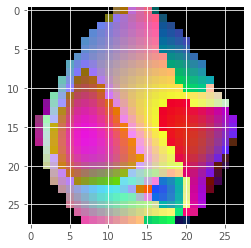

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
#plt.imshow(X[71433])
plt.imshow((X[798] * 255).astype(np.uint8))
#print(X[798])

In [54]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20,shuffle=True)

In [55]:
# input image dimensions
img_rows, img_cols = 28, 28

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

input_shape = (img_rows, img_cols, 3)

x_train shape: (63488, 28, 28, 3)
63488 train samples
15872 test samples


In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [64]:
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

# Initialising the CNN
classifier = Sequential()


classifier.add( Conv2D(32,(3,3), input_shape=X.shape[1:]) )#window
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size=(2,2)))

classifier.add(Conv2D(32,(3,3)))#window
classifier.add(Activation("relu"))
classifier.add(MaxPooling2D(pool_size=(2,2))) #2x64 convolutional neural net

classifier.add(Flatten())
classifier.add(Dense(64))# layer needs a 1d dataset
classifier.add(Activation("relu"))

classifier.add(Dense(1))
classifier.add(Activation('sigmoid'))


classifier.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 11, 11, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 800)             

In [67]:
classifier.compile(optimizer = 'rmsprop',
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [69]:
batch_size = 62
num_classes = 2
epochs = 1

history= classifier.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True)

Train on 63488 samples, validate on 15872 samples
Epoch 1/1
63488/63488 [==============================] - 13s 205us/step - loss: 0.6464 - accuracy: 0.6368 - val_loss: 0.6398 - val_accuracy: 0.6392


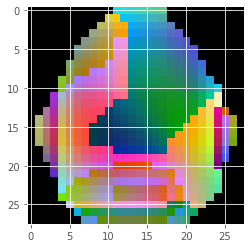

In [86]:
img_path = "/home/vikmachine/Desktop/research/recordings/sub5_trial15_img10.png"

img = image.load_img(img_path, target_size=(28, 28))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

In [89]:
activations = activation_model.predict(img_tensor)

In [90]:
layer_outputs = [layer.output for layer in classifier.layers[:3]] 
# Extracts the outputs of the top 3 layers
activation_model = models.Model(inputs=classifier.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

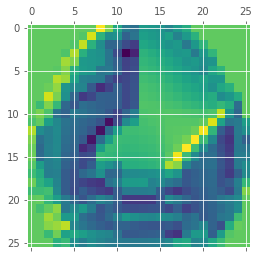

In [91]:
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

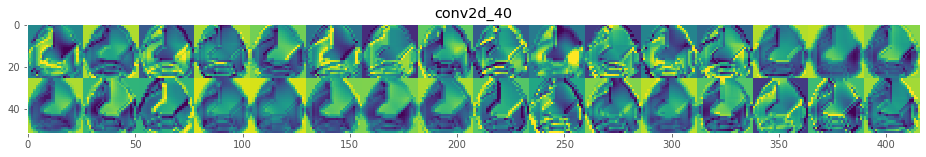

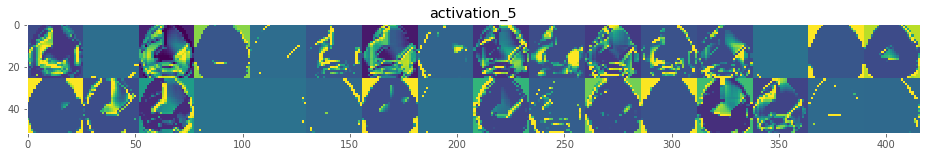

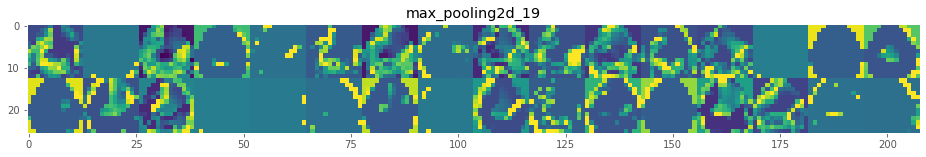

In [92]:
layer_names = []
for layer in classifier.layers[:3]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')